## Weight Initialisation

Below is presented the weight initialisation activation function coefficient generation script, whose results are presented in (Link Hidden for anonymous reviewing)

The current (published) methods of weight initialisation are:
 - He
   - $ w \in \mathcal{N}\left(0, \sqrt{\frac{2}{N_{in}}}\right) $
   - Used for the ReLU activation function
 - Xavier
   - $ w \in \mathcal{N}\left(0, \sqrt{\frac{6}{N_{in} + N_{out}}}\right) $
   - Used for the sigmoid and tanh (and other s-shape) activation functions

 This script generates the coefficients for performing Constant Variance weight initialisation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
import torch

import torchvision
from torchvision.transforms import Compose

In [2]:
# Build a basic neural network

# Number of layers in the network
layers = 10

layer_size = 100

# Basic neural network, has `layer_size` nodes per layer
class NeuralNetwork(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = []
        for _ in range(layers-1):
            self.linear_relu_stack.append(nn.Linear(layer_size, layer_size))
            self.linear_relu_stack.append(activation)
        self.linear_relu_stack.append(nn.Linear(layer_size, layer_size))
        self.lin = nn.Sequential(*self.linear_relu_stack)

    def forward(self, x):
        x = self.flatten(x)
        for mod in self.lin:
            x = mod(x)
        return x

device = "cuda"
n = NeuralNetwork()

In [3]:
##### INITIALISATION #####
# No initialisation, only use normal values
for p in n.modules():
    if p.__class__.__name__ == "Linear":
        with torch.no_grad():
            p.weight.normal_(0, 1)

In [4]:
##### Plot the distribution of the weights #####

# The variance of each layer is stored in this
layer_variances = []

# The variance of the values of the weights are stored in this, this is different
# from the values when passed through the layers, when the network is supplied an input
weight_vars = []
for p in n.modules():
    if p.__class__.__name__ == "Linear":
        # Only take the weights, ignore the biases
        layer_variances.append(torch.var(p.weight))
        weight_vars.append(torch.flatten(p.weight).detach().numpy())

del n

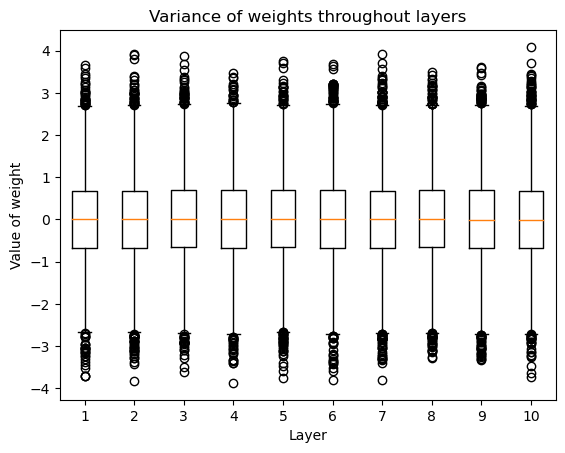

In [5]:
plt.boxplot(weight_vars)
plt.title("Variance of weights throughout layers")
plt.xlabel("Layer")
plt.ylabel("Value of weight")
plt.savefig('./WeightsThroughoutLayers.png', dpi=400)

In [3]:
# Now apply a random (normalised) input many times to determine the variance as the features are passed through the layers
def run_network(net):
    """ Run the network with a normalised input """
    # Register a forward hook to get the value of each layer
    layer_intermediate_values = {}
    def set_forward_hooks(name):
        def hook(model, input, output):
            layer_intermediate_values[name] = output.detach()
        return hook

    layerID = 0
    for m in net.modules():
        if m.__class__.__name__ == "Linear":
            m.register_forward_hook(set_forward_hooks(layerID))
            layerID += 1

    # Need to run network to get intermediate values
    _out = net(torch.normal(0, 1, size=(100, layer_size)))

    return layer_intermediate_values

layers_network = run_network(NeuralNetwork())

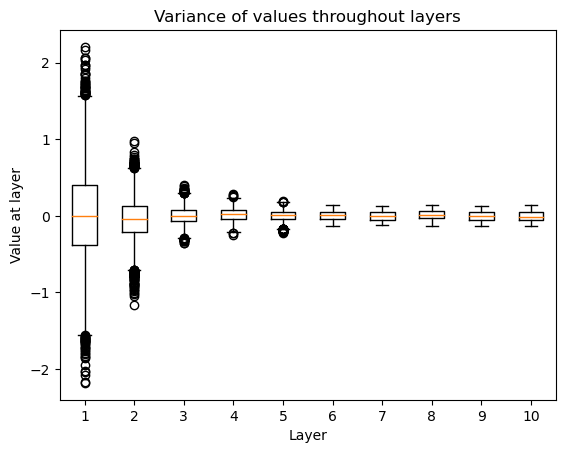

In [7]:
# Get the variance of the values as they propagate through each layer
npvals = [t.flatten().detach().numpy() for t in list(layers_network.values())]

plt.boxplot(npvals)
plt.title("Variance of values throughout layers")
plt.xlabel("Layer")
plt.ylabel("Value at layer")
plt.savefig('./VarianceThroughoutLayers.png', dpi=400)

print("", end="")

In [ ]:
# Empirical derivation of correct weight initialization

# To perform an empirical derivation, take any two layers
# and identify the difference in variance between them,
# then mitigate this using a constant factor

# Set up two layer neural network
class TwoLayerNeuralNetwork(nn.Module):
    def __init__(self, activation=nn.ReLU(), layer_size=200):
        super(TwoLayerNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = []

        self.linear_relu_stack.append(activation)
        self.linear_relu_stack.append(nn.Linear(layer_size, layer_size))

        self.lin = nn.Sequential(*self.linear_relu_stack)

    def forward(self, x):
        x = self.flatten(x)
        for mod in self.lin:
            x = mod(x)
        return x

def get_const_variance_multiplier(activation=nn.ReLU()):
    """
    Get the multiplier which gives constant variance across layers
    :param activation: The activation function to use in the network
    :return: The multiplier which gives a constant variance across the layers for the given activation function
    """
    # Run two layer neural network and record the difference in variance
    net = TwoLayerNeuralNetwork(activation).to(device)

    out_arr = []
    in_arr = []
    for _ in range(0, 1_000_000):
        # Use initialization by a normal distribution, assuming no activation
        for p in net.modules():
            if p.__class__.__name__ == "Linear":
                with torch.no_grad():
                    p.weight.normal_(0, 1/np.sqrt(200))

        in_val = torch.normal(0, 1, size=(1, 200)).to(device)
        in_arr.extend(in_val.detach().numpy().flatten())
        out = net(in_val).to("cpu")
        out_arr.extend(out.detach().numpy().flatten())

        del in_val
        del out
    del net

    multiplier = 1/np.std(out_arr)
    return multiplier, in_arr, out_arr

def get_const_variance_multiplier_s_shape(activation=nn.Tanh()):
    """
    Get the multiplier which gives constant variance across layers
    :param activation: The activation function to use in the network
    :return: The multiplier which gives a constant variance across the layers for the given activation function
    """
    # Run two layer neural network and record the difference in variance
    net = TwoLayerNeuralNetwork(activation).to(device)

    out_arr = []
    in_arr = []
    for _ in range(0, 1_000_000):
        # Use initialization by a normal distribution, assuming no activation
        for p in net.modules():
            if p.__class__.__name__ == "Linear":
                with torch.no_grad():
                    p.weight.normal_(0, 1/np.sqrt(200))
                    p.bias.zero_()

        in_val = torch.normal(0, 1, size=(1, 200)).to(device)
        in_arr.extend(in_val)
        out = net(in_val)
        out_arr.extend(out)

        del in_val
        del out
    del net

    multiplier = 1/torch.std(torch.stack(out_arr).flatten())
    return multiplier, in_arr, out_arr

def get_const_variance_multiplier_normal_gpu(activation=nn.Tanh()):
    """
    Get the multiplier which gives constant variance across layers
    :param activation: The activation function to use in the network
    :return: The multiplier which gives a constant variance across the layers for the given activation function
    """
    # Run two layer neural network and record the difference in variance
    net = TwoLayerNeuralNetwork(activation, 10_000).to(device)

    out_arr = []
    in_arr = []
    for _ in range(0, 10_000):
        # Use initialization by a normal distribution, assuming no activation
        for p in net.modules():
            if p.__class__.__name__ == "Linear":
                with torch.no_grad():
                    p.weight.normal_(0, 1/np.sqrt(10_000))
                    p.bias.zero_()

        in_val = torch.normal(0, 1, size=(1, 10_000)).to(device)
        in_arr.extend(in_val)
        out = net(in_val)
        out_arr.extend(out)

        del in_val
        del out
    del net

    multiplier = 1/torch.std(torch.stack(out_arr).flatten())
    return multiplier, in_arr, out_arr


def get_const_variance_multiplier_normal_half_std_gpu(activation=nn.Tanh()):
    """
    Get the multiplier which gives constant variance across layers
    :param activation: The activation function to use in the network
    :return: The multiplier which gives a constant variance across the layers for the given activation function
    """
    # Run two layer neural network and record the difference in variance
    net = TwoLayerNeuralNetwork(activation, 10_000).to(device)

    out_arr = []
    in_arr = []
    for _ in range(0, 10_000):
        # Use initialization by a normal distribution, assuming no activation
        for p in net.modules():
            if p.__class__.__name__ == "Linear":
                with torch.no_grad():
                    p.weight.normal_(0, 1/np.sqrt(10_000))
                    p.bias.zero_()

        in_val = torch.normal(0, 0.5, size=(1, 10_000)).to(device)
        in_arr.extend(in_val)
        out = net(in_val)
        out_arr.extend(out)

        del in_val
        del out
    del net

    multiplier = 0.5/torch.std(torch.stack(out_arr).flatten())
    return multiplier, in_arr, out_arr


def get_const_variance_multiplier_uniform_gpu(activation=nn.ReLU()):
    """
    Get the multiplier which gives constant variance across layers
    :param activation: The activation function to use in the network
    :return: The multiplier which gives a constant variance across the layers for the given activation function
    """
    # Run two layer neural network and record the difference in variance
    net = TwoLayerNeuralNetwork(activation, 10_000).to(device)

    out_arr = []
    in_arr = []
    for _ in range(0, 10_000):
        # Use initialization by a normal distribution, assuming no activation
        for p in net.modules():
            if p.__class__.__name__ == "Linear":
                with torch.no_grad():
                    p.weight.uniform_(-1/np.sqrt(10_000), 1/np.sqrt(10_000))
                    p.bias.zero_()

        in_val = torch.normal(0, 1, size=(1, 10_000)).to(device)
        in_arr.extend(in_val)
        out = net(in_val)
        out_arr.extend(out)

        del in_val
        del out
    del net

    multiplier = 1/torch.std(torch.stack(out_arr).flatten())
    return multiplier, in_arr, out_arr



def get_const_variance_multiplier_uniform(activation=nn.ReLU()):
    """
    Get the multiplier which gives constant variance across layers
    :param activation: The activation function to use in the network
    :return: The multiplier which gives a constant variance across the layers for the given activation function
    """
    # Run two layer neural network and record the difference in variance
    net = TwoLayerNeuralNetwork(activation).to(device)

    out_arr = []
    in_arr = []
    for _ in range(0, 1_000_000):
        # Use initialization by a normal distribution, assuming no activation
        for p in net.modules():
            if p.__class__.__name__ == "Linear":
                with torch.no_grad():
                    p.weight.uniform_(0, 1/np.sqrt(200))

        in_val = torch.normal(0, 1, size=(1, 200)).to(device)
        in_arr.extend(in_val.to("cpu").detach().numpy().flatten())
        out = net(in_val).to("cpu")
        out_arr.extend(out.detach().numpy().flatten())

        del in_val
        del out
    del net

    multiplier = 1/np.std(out_arr)
    return multiplier, in_arr, out_arr


In [ ]:
class Tanh2(nn.Module):
    r"""Applies the Linear-Tanh Guassian Interpolation function element-wise:

    :math:`\text{LiT}(x) = (x)^+ = \max(0, x)`

    Args:
        inplace: can optionally do the operation in-place. Default: ``False``

    Shape:
        - Input: :math:`(*)`, where :math:`*` means any number of dimensions.
        - Output: :math:`(*)`, same shape as the input.

    .. image:: ../scripts/activation_images/ReLU.png

    Examples::

        >>> m = nn.ReLU()
        >>> input = torch.randn(2)
        >>> output = m(input)


      An implementation of CReLU - https://arxiv.org/abs/1603.05201

        >>> m = nn.ReLU()
        >>> input = torch.randn(2).unsqueeze(0)
        >>> output = torch.cat((m(input),m(-input)))
    """
    __constants__ = ['inplace']
    inplace: bool

    def __init__(self, inplace: bool = False):
        super(Tanh2, self).__init__()
        self.inplace = inplace
        self.tanh = nn.Tanh()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.tanh(input/8)*8

    def extra_repr(self) -> str:
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str

In [ ]:
# And try that in an initialisation to verify

def run_network_with_multiplier(multiplier, activation=nn.ReLU()):
    """
    Run a two layer network to determine the correct multiplier to use to
    ensure constant variance

    :param multiplier: the multiplier to apply to the weights
    :param activation: the activation to apply to the nodes
    """
    # Run two layer neural network and record the difference in variance
    net = TwoLayerNeuralNetwork(activation)

    # Use initialization by a normal distribution, assuming no activation
    for p in net.modules():
        if p.__class__.__name__ == "Linear":
            with torch.no_grad():
                p.weight.normal_(0, multiplier/np.sqrt(100))

    out_arr = []
    in_arr = []
    for _ in range(0, 100_000):
        in_val = torch.normal(0, 1, size=(1, layer_size))
        in_arr.extend(in_val.detach().numpy().flatten())
        out = net(in_val)
        out_arr.extend(out.detach().numpy().flatten())
        del in_val
        del out

    in_var_new = np.var(in_arr)
    out_var_new  = np.var(out_arr)

    print("Layer 1: "+ str(in_var_new))
    print("Layer 2: "+ str(out_var_new))

    del in_var_new
    del out_var_new
    del net



In [ ]:
### Some basic tests to check the above code works ###
print(device)
print("=========================")
print("Tanh")
tanh_const_var_multiplier, _, _ = get_const_variance_multiplier_s_shape(torch.nn.Tanh())
print("Tanh Multiplier: " + str(tanh_const_var_multiplier))

In [ ]:
print(device)
print("=========================")
print("Tanh")
tanh_const_var_multiplier, in_arr, out_arr = get_const_variance_multiplier_normal_gpu(torch.nn.Tanh())
print("Tanh Multiplier: " + str(tanh_const_var_multiplier))

del in_arr
del out_arr

In [ ]:
print(device)
print("=========================")
print("Tanh")
tanh_const_var_multiplier_uniform, in_arr, out_arr = get_const_variance_multiplier_uniform_gpu(torch.nn.Tanh())
print("Tanh Multiplier: " + str(tanh_const_var_multiplier_uniform))

del in_arr
del out_arr

In [ ]:
# Set to True to calculate the coefficients
# or False to use pre-calculated coefficients
calculate_coefficients=True

relu_const_var_multiplier = 0
sigmoid_const_var_multiplier = 0
tanh_const_var_multiplier = 0
softsign_const_var_multiplier = 0
elu_const_var_multiplier = 0
gelu_const_var_multiplier = 0
silu_const_var_multiplier= 0
selu_const_var_multiplier = 0

if calculate_coefficients:
    print("ReLU")
    relu_const_var_multiplier, _, _ = get_const_variance_multiplier_normal_gpu(nn.ReLU())
    print("ReLU multiplier: " + str(relu_const_var_multiplier))
    #run_network_with_multiplier(relu_const_var_multiplier, nn.ReLU())

    print()
    print("=========================")
    print("Sigmoid")
    sigmoid_const_var_multiplier, _, _ = get_const_variance_multiplier_normal_gpu(nn.Sigmoid())
    print("Sigmoid Multiplier: " + str(sigmoid_const_var_multiplier))

    print()
    print("=========================")
    print("Tanh")
    tanh_const_var_multiplier, _, _ = get_const_variance_multiplier_normal_gpu(nn.Tanh())
    print("Tanh Multiplier: " + str(tanh_const_var_multiplier))

    print()
    print("=========================")
    print("SoftSign")
    softsign_const_var_multiplier, _, _ = get_const_variance_multiplier_normal_gpu(nn.Softsign())
    print("SoftSign Multiplier: " + str(softsign_const_var_multiplier))

    print()
    print("=========================")
    print("ELU")
    elu_const_var_multiplier, _, _ = get_const_variance_multiplier_normal_gpu(nn.ELU())
    print("ELU Multiplier: " + str(elu_const_var_multiplier))

    print()
    print("=========================")
    print("GELU")
    gelu_const_var_multiplier, _, _ = get_const_variance_multiplier_normal_gpu(nn.GELU())
    print("GELU Multiplier: " + str(gelu_const_var_multiplier))

    print()
    print("=========================")
    print("SiLU")
    silu_const_var_multiplier, _, _ = get_const_variance_multiplier_normal_gpu(nn.SiLU())
    print("SiLU Multiplier: " + str(silu_const_var_multiplier))

    print()
    print("=========================")
    print("SELU")
    selu_const_var_multiplier, _, _ = get_const_variance_multiplier_normal_gpu(nn.SELU())
    print("SELU Multiplier: " + str(selu_const_var_multiplier))


    with open("./coeffs.csv", "w+") as f:
        f.write("ReLU,"+str(relu_const_var_multiplier)+"\n")
        f.write("Sigmoid,"+str(sigmoid_const_var_multiplier)+"\n")
        f.write("Tanh,"+str(tanh_const_var_multiplier)+"\n")
        f.write("Softsign,"+str(softsign_const_var_multiplier)+"\n")
        f.write("ELU,"+str(elu_const_var_multiplier)+"\n")
        f.write("GELU,"+str(gelu_const_var_multiplier)+"\n")
        f.write("SiLU,"+str(silu_const_var_multiplier)+"\n")
        f.write("SELU,"+str(selu_const_var_multiplier)+"\n")
else:
    print("Loading coefficients from file...")
    with open("./coeffs.csv", "r") as f:
        for line in f.readlines():
            line = line.split(",")
            if line[0] == "ReLU":
                relu_const_var_multiplier = float(line[1])
                print("ReLU: "+str(relu_const_var_multiplier))
            elif line[0] == "Sigmoid":
                sigmoid_const_var_multiplier = float(line[1])
                print("Sigmoid: "+str(sigmoid_const_var_multiplier))
            elif line[0] == "Tanh":
                tanh_const_var_multiplier = float(line[1])
                print("Tanh: "+str(tanh_const_var_multiplier))
            elif line[0] == "Softsign":
                softsign_const_var_multiplier = float(line[1])
                print("Softsign: "+str(softsign_const_var_multiplier))
            elif line[0] == "ELU":
                elu_const_var_multiplier = float(line[1])
                print("ELU: "+str(elu_const_var_multiplier))
            elif line[0] == "GELU":
                gelu_const_var_multiplier = float(line[1])
                print("GELU: "+str(gelu_const_var_multiplier))
            elif line[0] == "SiLU":
                silu_const_var_multiplier = float(line[1])
                print("SiLU: "+str(silu_const_var_multiplier))

In [ ]:
print("ReLU: " + str(relu_const_var_multiplier))
print("Sigmoid: " + str(sigmoid_const_var_multiplier))
print("TanH: " + str(tanh_const_var_multiplier))
print("Softsign: " + str(softsign_const_var_multiplier))
print("ELU: " + str(elu_const_var_multiplier))
print("GELU: " + str(gelu_const_var_multiplier))
print("SiLU: " + str(silu_const_var_multiplier))
print("SELU: " + str(selu_const_var_multiplier))

In [ ]:
# Set to True to calculate the coefficients
# or False to use pre-calculated coefficients
calculate_coefficients=True

relu_const_var_multiplier_uniform = 0
sigmoid_const_var_multiplier_uniform = 0
tanh_const_var_multiplier_uniform = 0
softsign_const_var_multiplier_uniform = 0
elu_const_var_multiplier_uniform = 0
gelu_const_var_multiplier_uniform = 0
silu_const_var_multiplier_uniform = 0
selu_const_var_multiplier_uniform = 0

if calculate_coefficients:
    print("ReLU")
    relu_const_var_multiplier_uniform, _, _ = get_const_variance_multiplier_uniform_gpu(nn.ReLU())
    print("ReLU multiplier: " + str(relu_const_var_multiplier_uniform))

    print()
    print("=========================")
    print("Sigmoid")
    sigmoid_const_var_multiplier_uniform, _, _ = get_const_variance_multiplier_uniform_gpu(nn.Sigmoid())
    print("Sigmoid Multiplier: " + str(sigmoid_const_var_multiplier_uniform))

    print()
    print("=========================")
    print("Tanh")
    tanh_const_var_multiplier_uniform, _, _ = get_const_variance_multiplier_uniform_gpu(nn.Tanh())
    print("Tanh Multiplier: " + str(tanh_const_var_multiplier_uniform))

    print()
    print("=========================")
    print("SoftSign")
    softsign_const_var_multiplier_uniform, _, _ = get_const_variance_multiplier_uniform_gpu(nn.Softsign())
    print("SoftSign Multiplier: " + str(softsign_const_var_multiplier_uniform))

    print()
    print("=========================")
    print("ELU")
    elu_const_var_multiplier_uniform, _, _ = get_const_variance_multiplier_uniform_gpu(nn.ELU())
    print("ELU Multiplier: " + str(elu_const_var_multiplier_uniform))

    print()
    print("=========================")
    print("GELU")
    gelu_const_var_multiplier_uniform, _, _ = get_const_variance_multiplier_uniform_gpu(nn.GELU())
    print("GELU Multiplier: " + str(gelu_const_var_multiplier_uniform))

    print()
    print("=========================")
    print("SiLU")
    silu_const_var_multiplier_uniform, _, _ = get_const_variance_multiplier_uniform_gpu(nn.SiLU())
    print("SiLU Multiplier: " + str(silu_const_var_multiplier_uniform))

    print()
    print("=========================")
    print("SELU")
    selu_const_var_multiplier_uniform, _, _ = get_const_variance_multiplier_uniform_gpu(nn.SELU())
    print("SELU Multiplier: " + str(selu_const_var_multiplier_uniform))

    with open("./coeffs_uniform2.csv", "w+") as f:
        f.write("ReLU,"+str(relu_const_var_multiplier_uniform)+"\n")
        f.write("Sigmoid,"+str(sigmoid_const_var_multiplier_uniform)+"\n")
        f.write("Tanh,"+str(tanh_const_var_multiplier_uniform)+"\n")
        f.write("Softsign,"+str(softsign_const_var_multiplier_uniform)+"\n")
        f.write("ELU,"+str(elu_const_var_multiplier_uniform)+"\n")
        f.write("GELU,"+str(gelu_const_var_multiplier_uniform)+"\n")
        f.write("SiLU,"+str(silu_const_var_multiplier_uniform)+"\n")
        f.write("SELU,"+str(selu_const_var_multiplier_uniform)+"\n")

In [ ]:
print("ReLU: " + str(relu_const_var_multiplier_uniform))
print("Sigmoid: " + str(sigmoid_const_var_multiplier_uniform))
print("TanH: " + str(tanh_const_var_multiplier_uniform))
print("Softsign: " + str(softsign_const_var_multiplier_uniform))
print("ELU: " + str(elu_const_var_multiplier_uniform))
print("GELU: " + str(gelu_const_var_multiplier_uniform))
print("SiLU: " + str(silu_const_var_multiplier_uniform))
print("SELU: " + str(selu_const_var_multiplier_uniform))

In [ ]:
# Also calculate coefficients for the tan8 activation function and half std propagation
class Tanh8(nn.Module):
    __constants__ = ['inplace']
    inplace: bool

    def __init__(self, inplace: bool = False):
        super(Tanh8, self).__init__()
        self.inplace = inplace
        self.tanh = nn.Tanh()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.tanh(input/8)*8

    def extra_repr(self) -> str:
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str

In [ ]:
print()
print("=========================")
print("Tanh8")
tanh8_const_var_multiplier, _, _ = get_const_variance_multiplier_normal_gpu(Tanh8())
print("Tanh8 Multiplier: " + str(tanh8_const_var_multiplier))

In [ ]:
train_transform_half_std = transform = Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    lambda x: torchvision.transforms.Normalize(torch.mean(x), torch.std(x), inplace=True)(x) * 0.5
])

# The dataset applied through the validation transform
validation_transform_half_std = transform = Compose([
    lambda x: torchvision.transforms.Normalize(torch.mean(x), torch.std(x), inplace=True)(x) * 0.5])

In [ ]:
print()
print("=========================")
print("Tanh Half Std")
tanh_const_var_half_std_multiplier, _, _ = get_const_variance_multiplier_normal_half_std_gpu(nn.Tanh())
print("Tanh Half Std Multiplier: " + str(tanh_const_var_half_std_multiplier))


In [10]:
# Also calculate coefficients for the tan8 activation function and half std propagation
class Tanh8(nn.Module):
    __constants__ = ['inplace']
    inplace: bool

    def __init__(self, inplace: bool = False):
        super(Tanh8, self).__init__()
        self.inplace = inplace
        self.tanh = nn.Tanh() #inplace=self.inplace

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.tanh(input/8)*8 #, inplace=self.inplace

    def extra_repr(self) -> str:
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str

In [11]:
print()
print("=========================")
print("Tanh8")
tanh8_const_var_multiplier, _, _ = get_const_variance_multiplier_normal_gpu(Tanh8())
print("Tanh8 Multiplier: " + str(tanh8_const_var_multiplier))


Tanh8
Tanh8 Multiplier: tensor(1.0153, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
train_transform_half_std = transform=Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    lambda x: torchvision.transforms.Normalize(torch.mean(x), torch.std(x), inplace=True)(x) * 0.5
])

# The dataset applied through the validation transform
validation_transform_half_std = transform=Compose([
    lambda x: torchvision.transforms.Normalize(torch.mean(x), torch.std(x), inplace=True)(x) * 0.5])

In [15]:
print()
print("=========================")
print("Tanh Half Std")
tanh_const_var_half_std_multiplier, _, _ = get_const_variance_multiplier_normal_half_std_gpu(nn.Tanh())
print("Tanh Half Std Multiplier: " + str(tanh_const_var_half_std_multiplier))



Tanh Half Std
Tanh Half Std Multiplier: tensor(1.2003, device='cuda:0', grad_fn=<MulBackward0>)


In [6]:
print("Mish")
mish_const_var_multiplier, _, _ = get_const_variance_multiplier_normal_gpu(nn.Mish())
print("Mish multiplier: " + str(relu_const_var_multiplier_uniform))

Mish
Mish multiplier: tensor(1.4867, device='cuda:0', grad_fn=<MulBackward0>)


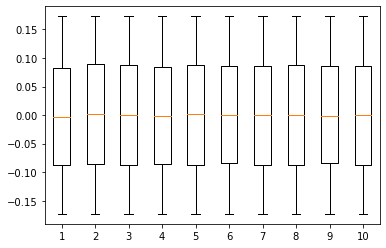

In [21]:
### Check that Xavier initialisation is doing the correct ###

# Xavier initialisation
net_xavier=NeuralNetwork(activation=nn.Tanh()) #TwoLayerNeuralNetwork()

# Considers not only the input, but also the output
for p in net_xavier.modules():
    if p.__class__.__name__ == "Linear":
        with torch.no_grad():
            nn.init.xavier_uniform_(p.weight)

# Apply random input and measure variance after each input at each layer
layer_variances = []
weight_vars = []
for p in net_xavier.modules():
    if p.__class__.__name__ == "Linear":
        # Only take the weights, ignore the biases
        layer_variances.append(torch.var(p.weight))
        weight_vars.append(torch.flatten(p.weight).detach().numpy())

plt.boxplot(weight_vars)

del net_xavier
del weight_vars
del layer_variances

plt.show()

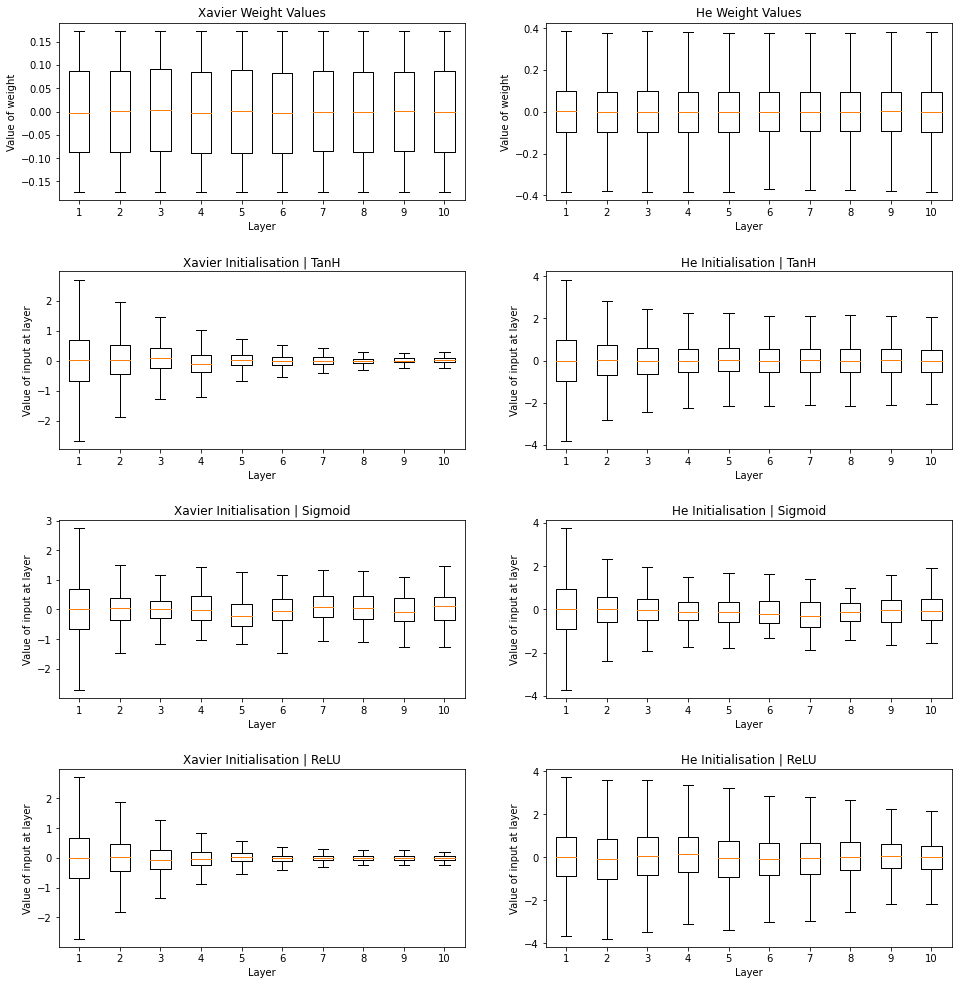

In [25]:
### Get the variance of the forward propagated input throughout the layers of the neural network ###

def run_xavier(activation=nn.Sigmoid()):
    """ Run a neural network with Xavier initialisation """
    net_xavier=NeuralNetwork(activation)

    for p in net_xavier.modules():
        if p.__class__.__name__ == "Linear":
            with torch.no_grad():
                nn.init.xavier_uniform_(p.weight)

    layer_vals_xavier = run_network(net_xavier)
    return layer_vals_xavier

def run_he(activation=nn.Sigmoid()):
    """ Run a neural network with He initialisation """
    net_he=NeuralNetwork(activation)

    for p in net_he.modules():
        if p.__class__.__name__ == "Linear":
            with torch.no_grad():
                nn.init.kaiming_normal_(p.weight)

    layer_vals_xavier = run_network(net_he)
    return layer_vals_xavier


############################################
############################################

net_xavier=NeuralNetwork()

for p in net_xavier.modules():
    if p.__class__.__name__ == "Linear":
        with torch.no_grad():
            nn.init.xavier_uniform_(p.weight)

layer_variances_xavier = []
weight_vars_xavier = []
for p in net_xavier.modules():
    if p.__class__.__name__ == "Linear":
        layer_variances_xavier.append(torch.var(p.weight))
        weight_vars_xavier.append(torch.flatten(p.weight).detach().numpy())


net_he=NeuralNetwork()

for p in net_he.modules():
    if p.__class__.__name__ == "Linear":
        with torch.no_grad():
            nn.init.kaiming_normal_(p.weight)

layer_variances_he = []
weight_vars_he = []
for p in net_he.modules():
    if p.__class__.__name__ == "Linear":
        layer_variances_he.append(torch.var(p.weight))
        weight_vars_he.append(torch.flatten(p.weight).detach().numpy())


############################################
############################################

layer_vals_xavier_tanh = run_network(net_xavier)

show_outliers = False

fig, (row1, row2, row3, row4) = plt.subplots(nrows=4, ncols=2,figsize=(16, 17), gridspec_kw={"hspace": 0.4})
row1[0].boxplot(weight_vars_xavier)
row1[0].set_title("Xavier Weight Values")
row1[0].set_xlabel("Layer")
row1[0].set_ylabel("Value of weight")

row1[1].boxplot(weight_vars_he, showfliers=show_outliers)
row1[1].set_title("He Weight Values")
row1[1].set_xlabel("Layer")
row1[1].set_ylabel("Value of weight")

## Tanh
row2[0].boxplot([torch.flatten(v).detach().numpy() for v in layer_vals_xavier_tanh.values()], showfliers=show_outliers)
row2[0].set_title("Xavier Initialisation | TanH")
row2[0].set_xlabel("Layer")
row2[0].set_ylabel("Value of input at layer")

row2[1].boxplot([torch.flatten(v).detach().numpy() for v in run_he(nn.Tanh()).values()], showfliers=show_outliers)
row2[1].set_title("He Initialisation | TanH")
row2[1].set_xlabel("Layer")
row2[1].set_ylabel("Value of input at layer")

## Sigmoid
row3[0].boxplot([torch.flatten(v).detach().numpy() for v in run_xavier().values()], showfliers=show_outliers)
row3[0].set_title("Xavier Initialisation | Sigmoid")
row3[0].set_xlabel("Layer")
row3[0].set_ylabel("Value of input at layer")

row3[1].boxplot([torch.flatten(v).detach().numpy() for v in run_he(nn.Sigmoid()).values()], showfliers=show_outliers)
row3[1].set_title("He Initialisation | Sigmoid")
row3[1].set_xlabel("Layer")
row3[1].set_ylabel("Value of input at layer")

## ReLU
row4[0].boxplot([torch.flatten(v).detach().numpy() for v in run_xavier(nn.ReLU()).values()], showfliers=show_outliers)
row4[0].set_title("Xavier Initialisation | ReLU")
row4[0].set_xlabel("Layer")
row4[0].set_ylabel("Value of input at layer")

row4[1].boxplot([torch.flatten(v).detach().numpy() for v in run_he(nn.ReLU()).values()], showfliers=show_outliers)
row4[1].set_title("He Initialisation | ReLU")
row4[1].set_xlabel("Layer")
row4[1].set_ylabel("Value of input at layer")

plt.savefig("./XavierHe10Layer.png", dpi=360, bbox_inches="tight")

del layer_vals_xavier_tanh

C:\Users\rmen2\AppData\Local\Temp\ipykernel_23592\4041210845.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  conf_intervals = [(-(1/abs(np.sqrt(2)**i-np.sqrt(6)**i)), 1/abs(np.sqrt(2)**i-np.sqrt(6)**i)) for i in range(11)]


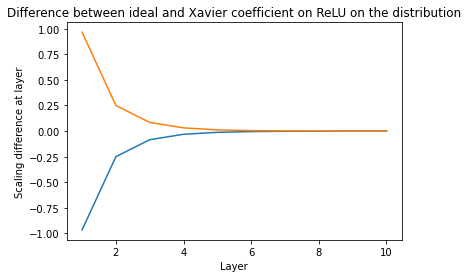

In [17]:
# Show the difference between constant variance initialisation and
# He and Xavier, smaller is worse and will likely require longer to train

# To measure the difference, use 1/abs(var1 - var2), this is the divergence from the ideal initialisation
conf_intervals = [(-(1/abs(np.sqrt(2)**i-np.sqrt(6)**i)), 1/abs(np.sqrt(2)**i-np.sqrt(6)**i)) for i in range(11)]

plt.plot(conf_intervals)
plt.title("Difference between ideal and Xavier coefficient on ReLU on the distribution")
plt.xlabel("Layer")
plt.ylabel("Scaling difference at layer")

plt.show()

In [19]:
### For completeness, also show constant variance initialisation ###

def const_var_init(activation=nn.Sigmoid(), coefficient=1.0):
    net_ana=NeuralNetwork(activation)
    for p in net_ana.modules():
        if p.__class__.__name__ == "Linear":
            with torch.no_grad():
                p.weight.normal_(0, coefficient/np.sqrt(100))
    return run_network(net_ana)

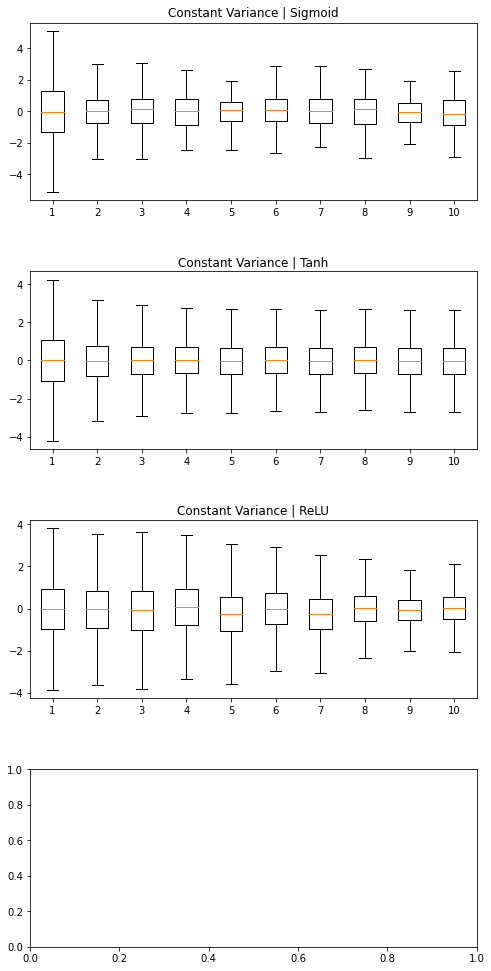

In [20]:

show_outliers = False

fig, rows = plt.subplots(nrows=4, ncols=1,figsize=(8, 17), gridspec_kw={"hspace": 0.4})

## Sigmoid
rows[0].boxplot([torch.flatten(v).detach().numpy() for v in const_var_init(nn.Sigmoid(), 1.926).values()], showfliers=show_outliers)
rows[0].set_title("Constant Variance | Sigmoid")

## Tanh
rows[1].boxplot([torch.flatten(v).detach().numpy() for v in const_var_init(nn.Tanh(), 1.58).values()], showfliers=show_outliers)
rows[1].set_title("Constant Variance | Tanh")

## ReLU
rows[2].boxplot([torch.flatten(v).detach().numpy() for v in const_var_init(nn.ReLU(), 1.41).values()], showfliers=show_outliers)
rows[2].set_title("Constant Variance | ReLU")

print()